<font color="orange">Multilevel Monte Carlo simulation for VIX options in the rough
Bergomi model</font>

Convention is different. The parameter $\eta$ in the paper must be 
replaced with $\eta \sqrt{2H}$

Let $\Delta = 30$ days. The VIX is defined as 

$$
    \text{VIX}_T = \sqrt{\frac1\Delta \int_{T}^{T+\Delta} \xi_T^u \, du}
$$

where, for all $u \geq T$,

$$
    \xi_T^u = \xi_0^u 
    \exp\left\{ \eta Y_T^u - \eta^2(u^{2H} - (u-T)^{2H})\right\}
$$

and

$$
    Y_T^u = \sqrt{2H} \int_0^T (u-s)^{H-1/2} \, dW_s
$$

We need to compute the covariance matrix of the vector 
$(Y_T^{u_i})_{0 \leq i \leq n}$ where $u_i = T + i \Delta/n$ for $i = 0, 1, \ldots, n$.

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
import matplotlib.pyplot as plt
from rbergomi import RoughBergomi
import matplotlib as mpl
import numpy as np
import seaborn as sns

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
COLORS = ["blue", "green", "red"]
SEED = 1234

For $n \in \mathbb{N}^*$ timesteps, 
consider the uniform grid $u_i = T + i \Delta/n$ for $i = 0, 1, \ldots, n$.

We are interested in the right-point rectangle scheme

$$
    \text{VIX}_T^{2,\mathcal{R}_n}
    = \frac{1}{n} \sum_{i=1}^{n} \xi_T^{u_i}
$$

and the trapezoidal scheme

$$
    \text{VIX}_T^{2,\mathcal{T}_n}
    = \frac{1}{2n} \sum_{i=1}^{n} 
    \left(\xi_T^{u_{i-1}} + \xi_T^{u_i}\right)
$$

Observe that $\{\log \xi_{T}^{u_i}\}_{0 \leq i \leq n}$
forms an $(n+1)$-dimensional Gaussian vector with mean vector 
$\mu = \{\mu_i\}_{0 \leq i \leq n}$ and covariance matrix $C = \{C_{i,j}\}_{0 \leq i,j \leq n}$
defined as

$$
    \mu_i = \log \xi_0^{u_i} - \frac{\eta^2}{2} (u_i^{2H} - (u_i-T)^{2H})
$$

and 

$$
    C_{i,j} = 2 H \int_0^T (u_i-s)^{H-1/2} (u_j-s)^{H-1/2} \, ds
$$

The covariance matrix term $C_{i,j}$ can be computed using the Gaussian 
hypergeometric function.

A Monte Carlo estimator for the price of a VIX option with payoff $\varphi$ is

$$
    \mathbb{E}[\varphi(\text{VIX}_T^{2})] 
    \approx \frac{1}{M} \sum_{m=1}^{M} 
    \varphi \left(\frac{1}{n} \sum_{i=1}^{n} \exp\{X_T^{u_i,m}\}\right)
$$

where $X_T^u = \log \xi_T^u$. 

A natural control variate is the lognormal random variable
$\exp\left\{\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i} \right\}$. Observe that
$\frac{1}{n} \sum_{i=1}^{n}X_T^{u_i}$ is normal with mean and standard deviation

$$
    \bar{\mu}_n = \frac{1}{n} \sum_{i=1}^{n} \mu_i,
    \qquad
    \bar{\sigma}_n = \sqrt{\frac{1}{n^2} \sum_{i,j=1}^{n} C_{i,j}}
$$




In [3]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.3**2,
    "rho": -0.7,
    "H": 0.4,
}
params["eta"] = 0.4 * np.sqrt(2.0 * params["H"])

rbergomi = RoughBergomi(**params)

# $L^2$ error for the strong error

In [21]:
T = 3.0 / 12.0
n_mc = 1 * 10**5
n_disc_ref = 2000

In [ ]:
# Simulate xi_{T}^{u_i}, shape is (n_disc+1, n_mc)
xi = rbergomi.simulate_vix(T=T, n_mc=n_mc, n_disc=n_disc_ref, seed=SEED, return_xi=True)

In [64]:
vix2_right_ref = np.mean(np.exp(xi[1:, :]), axis=0)
vix2_trap_ref = 0.5 * np.mean(np.exp(xi[:-1, :]) + np.exp(xi[1:, :]), axis=0)

In [65]:
tab_n_disc = [25, 40, 50, 80, 100, 125, 200, 250]
vix2_right = np.zeros((len(tab_n_disc), n_mc))
vix2_trap = np.zeros_like(vix2_right)

for i in range(len(tab_n_disc)):
    idx = np.arange(start=0, stop=n_disc_ref, step=n_disc_ref // tab_n_disc[i])
    vix2_right[i, :] = np.mean(np.exp(xi[1:, :][idx, :]), axis=0)
    vix2_trap[i, :] = 0.5 * np.mean(
        np.exp(xi[:-1, :][idx, :]) + np.exp(xi[1:, :][idx, :]), axis=0
    )

In [66]:
strong_error_right = np.mean((vix2_right_ref - vix2_right) ** 2, axis=1) ** 0.5
strong_error_trap = np.mean((vix2_trap_ref - vix2_trap) ** 2, axis=1) ** 0.5

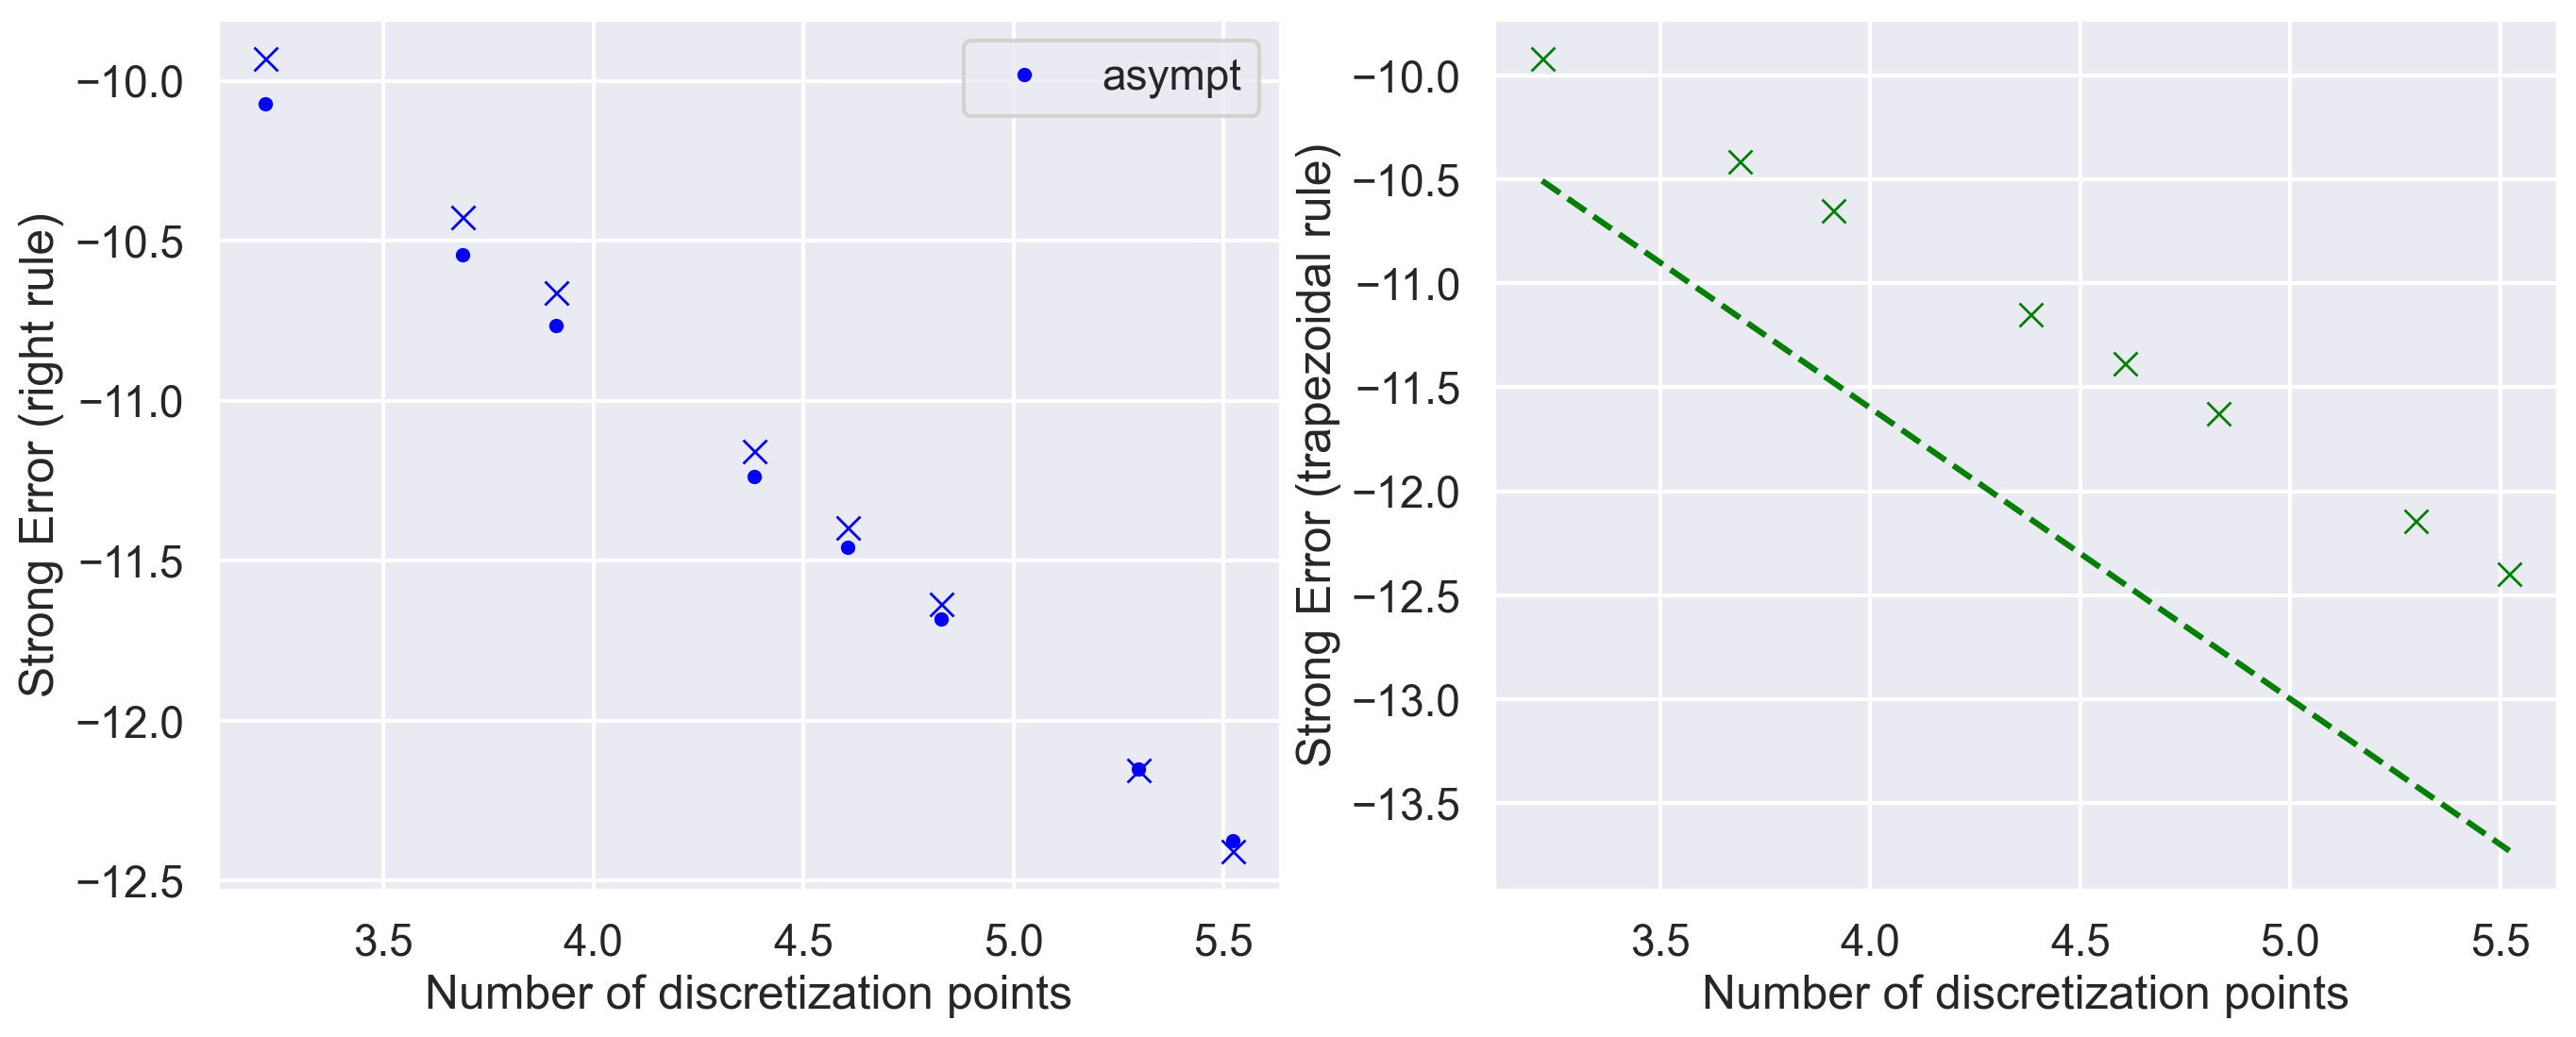

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(strong_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    np.log(rbergomi.limit_strong_error_vix_right(n=tab_n_disc, T=T)),
    ".",
    color=COLORS[0],
    label="asympt",
)
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Strong Error (right rule)")
ax[0].legend()
ax[1].plot(
    np.log(tab_n_disc),
    np.log(strong_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 6,
    "--",
    color=COLORS[1],
)
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Strong Error (trapezoidal rule)")
plt.show()

# Weak error

In [84]:
call_atm_right_ref = np.maximum(
    vix2_right_ref**0.5 - np.mean(vix2_right_ref**0.5), 0.0
).mean()
call_atm_trap_ref = np.maximum(
    vix2_trap_ref**0.5 - np.mean(vix2_trap_ref**0.5), 0.0
).mean()

In [85]:
call_atm_right = np.zeros(len(tab_n_disc))
call_atm_trap = np.zeros_like(call_atm_right)

for i in range(len(tab_n_disc)):
    call_atm_right[i] = np.maximum(
        vix2_right[i, :] ** 0.5 - np.mean(vix2_right[i, :] ** 0.5), 0.0
    ).mean()
    call_atm_trap[i] = np.maximum(
        vix2_trap[i, :] ** 0.5 - np.mean(vix2_trap[i, :] ** 0.5), 0.0
    ).mean()

In [88]:
weak_error_right = np.abs(call_atm_right_ref - call_atm_right)
weak_error_trap = np.abs(call_atm_trap_ref - call_atm_trap)

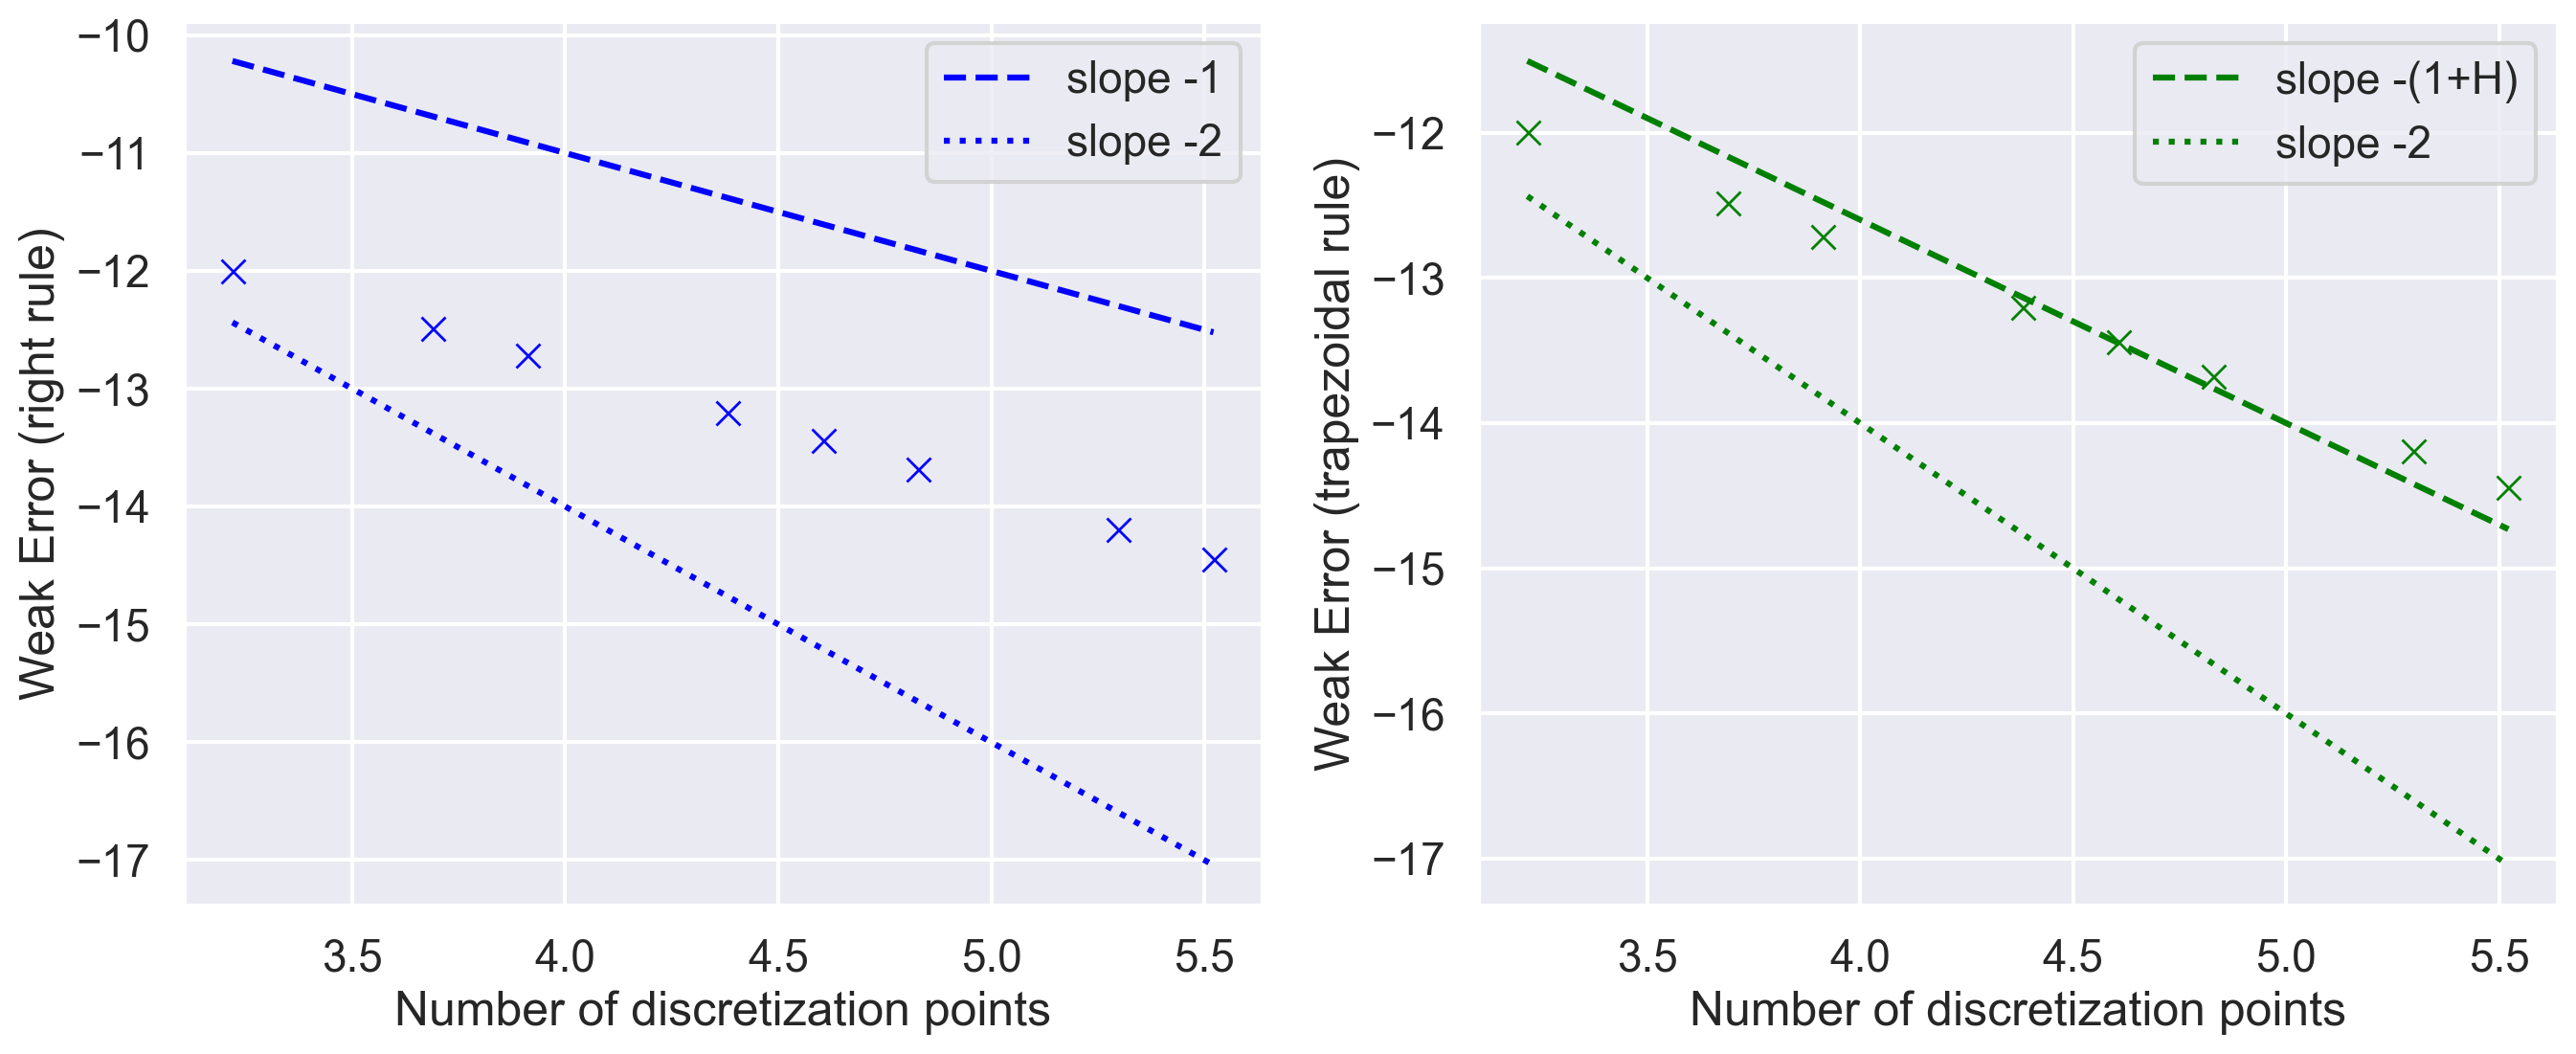

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 6))
ax[0].plot(
    np.log(tab_n_disc),
    np.log(weak_error_right),
    "x",
    color=COLORS[0],
)
ax[0].plot(
    np.log(tab_n_disc),
    -np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[0],
    label="slope -1",
)
ax[0].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[0],
    label="slope -2",
)
ax[0].legend()
ax[0].set_xlabel("Number of discretization points")
ax[0].set_ylabel("Weak Error (right rule)")
ax[1].plot(
    np.log(tab_n_disc),
    np.log(weak_error_trap),
    "x",
    color=COLORS[1],
)
ax[1].plot(
    np.log(tab_n_disc),
    -(1 + rbergomi.H) * np.log(tab_n_disc) - 7,
    "--",
    color=COLORS[1],
    label="slope -(1+H)",
)
ax[1].plot(
    np.log(tab_n_disc),
    -2 * np.log(tab_n_disc) - 6,
    ":",
    color=COLORS[1],
    label="slope -2",
)
ax[1].legend()
ax[1].set_xlabel("Number of discretization points")
ax[1].set_ylabel("Weak Error (trapezoidal rule)")
plt.show()

# Multilevel Monte Carlo

We price an ATM VIX call option.

In [48]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.235**2,
    "rho": -0.7,
    "H": 0.1,
    "eta": 0.3,
}

rbergomi = RoughBergomi(**params)

In [53]:
T = 0.5
tab_eps = np.linspace(3 * 10 ** (-2), 9.9 * 10 ** (-2), 10)

In [ ]:
n_disc_ref = 500
n_mc_ref = 3 * 10**5

In [51]:
vix_atm_call = rbergomi.price_vix(
    k=0.0, T=T, n_mc=n_mc_ref, n_disc=n_disc_ref, seed=SEED, rule="trap"
)

In [59]:
n_mc_eps = np.ceil(tab_eps ** (-2)).astype(int)
n_disc_eps = np.ceil(tab_eps ** (-1)).astype(int)

In [ ]:
mc_eps = np.zeros_like(n_mc_eps)

array([1112,  705,  487,  356,  272,  215,  174,  143,  120,  103])

In [24]:
def params_mlmc(K, T, n_disc_0, eps, option="rec"):
    # Lipschitz constant when payoff = max(np.sqrt(x)-strike, 0) -> call
    lip = 1 / (2 * K)
    lim = rbergomi.limit_strong_error_vix_right(n=n_disc_0, T=T)
    c2 = 10 * (lip * lim) ** 2
    c1 = lip * lim
    level_max = int(np.ceil(np.log(np.sqrt(2) * c1 / eps) / np.log(2)))
    if level_max <= 0:
        raise ValueError("level_max must be >= 1.")
    n_mc_0 = int(np.ceil((2.0 / eps**2) * c2 * (level_max + 1)))
    n_disc_levels = np.array(
        [int(n_disc_0 * 2**level) for level in range(level_max + 1)]
    )

    if option == "rec":
        n_mc_levels = np.array(
            [max(1, int(n_mc_0 / 2 ** (2 * level))) for level in range(level_max + 1)]
        )
    elif option == "trap":
        n_mc_levels = np.array(
            [
                max(1, int(n_mc_0 / 2 ** ((2.0 + rbergomi.H) * level)))
                for level in range(level_max + 1)
            ]
        )
    else:
        raise ValueError("Unknown option: choose 'rec' or 'trap'")
    cost = int(np.sum(n_disc_levels * n_mc_levels**2))
    return (n_disc_levels, n_mc_levels, level_max, cost)

In [28]:
params_mlmc(K=0.2, T=T, n_disc_0=1.0, eps=1e-2)

(array([1, 2]), array([34,  8]), 1, 1284)

# Appendix: control variate

In [ ]:
# add example and fix problems.
# also, add control variate for call and put options.

In [4]:
params = {
    "s0": 1.0,
    "xi0": lambda u: np.ones_like(u) * 0.3**2,
    "rho": -0.7,
    "H": 0.3,
    "eta": 0.8,
}

rbergomi = RoughBergomi(**params)

In [20]:
T = 0.5
n_mc = 3 * 10**5
n_disc = 200
rule = "right"

vix, vix_cv = rbergomi.simulate_vix(
    T=T, n_mc=n_mc, n_disc=n_disc, seed=SEED, control_variate=True, rule=rule
)

In [21]:
np.maximum(vix - vix.mean(), 0.0).mean()

np.float64(0.03386377693970982)

In [25]:
(
    np.maximum(vix - vix.mean(), 0.0).mean()
    - np.maximum(vix_cv - vix_cv.mean(), 0.0).mean()
    + rbergomi.price_vix_control_variate(T=T, K=vix_cv.mean(), n_disc=n_disc, rule=rule)
)

np.float64(0.03388903265061207)

In [30]:
k = np.linspace(-0.1, 0.1, 5)

In [31]:
rbergomi.price_vix(k=k, T=T, n_mc=n_mc, n_disc=n_disc, rule=rule, control_variate=False)

array([0.04768433, 0.04046798, 0.03382367, 0.02781293, 0.02247727])

In [ ]:
rbergomi.price_vix(k=k, T=T, n_mc=n_mc, n_disc=n_disc, rule=rule, control_variate=True)

array([0.04768023])

In [ ]:
# TODO: clean control_vatiate option in methods.